In [196]:
library(tidyverse)
library(rvest)
library(stringr)
library(repr)
library(tidymodels)
library(infer)
library(dplyr)
library(plyr)

In [197]:
# Reading Data
id <- "1InFZlQaj3VzFHzhh5j8WJyDf4HmcD__-" # google file ID
vpd_crime_data <- read.csv(sprintf("https://docs.google.com/uc?id=%s&export=download", id))
vpd_crime_data <- na.omit(vpd_crime_data)
head(vpd_crime_data)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Theft of Vehicle,2020,4,19,21,30,29XX SLOCAN ST,Renfrew-Collingwood,496397.5,5456123
2,Theft of Vehicle,2020,2,21,1,43,29XX VENABLES ST,Hastings-Sunrise,496801.2,5458182
3,Theft of Vehicle,2020,2,11,1,30,29XX VIRTUAL WAY,Renfrew-Collingwood,497011.9,5456474
4,Theft of Vehicle,2020,5,16,22,0,29XX W 10TH AVE,Kitsilano,487613.2,5456729
5,Theft of Vehicle,2020,1,1,12,0,29XX WOODLAND DR,Kensington-Cedar Cottage,494641.9,5456214
6,Theft of Vehicle,2020,11,22,0,37,2X E CORDOVA ST,Central Business District,492453.1,5458847


In [198]:
str(vpd_crime_data)

'data.frame':	37491 obs. of  10 variables:
 $ TYPE         : chr  "Theft of Vehicle" "Theft of Vehicle" "Theft of Vehicle" "Theft of Vehicle" ...
 $ YEAR         : int  2020 2020 2020 2020 2020 2020 2020 2020 2020 2020 ...
 $ MONTH        : int  4 2 2 5 1 11 8 12 1 4 ...
 $ DAY          : int  19 21 11 16 1 22 17 24 1 8 ...
 $ HOUR         : int  21 1 1 22 12 0 21 23 0 21 ...
 $ MINUTE       : int  30 43 30 0 0 37 0 30 0 0 ...
 $ HUNDRED_BLOCK: chr  "29XX SLOCAN ST" "29XX VENABLES ST" "29XX VIRTUAL WAY" "29XX W 10TH AVE" ...
 $ NEIGHBOURHOOD: chr  "Renfrew-Collingwood" "Hastings-Sunrise" "Renfrew-Collingwood" "Kitsilano" ...
 $ X            : num  496397 496801 497012 487613 494642 ...
 $ Y            : num  5456123 5458182 5456474 5456729 5456214 ...
 - attr(*, "na.action")= 'omit' Named int 1081
  ..- attr(*, "names")= chr "1081"


In [199]:
summary(vpd_crime_data)

     TYPE                YEAR          MONTH             DAY       
 Length:37491       Min.   :2020   Min.   : 1.000   Min.   : 1.00  
 Class :character   1st Qu.:2020   1st Qu.: 3.000   1st Qu.: 8.00  
 Mode  :character   Median :2020   Median : 6.000   Median :15.00  
                    Mean   :2020   Mean   : 6.175   Mean   :15.16  
                    3rd Qu.:2020   3rd Qu.: 9.000   3rd Qu.:23.00  
                    Max.   :2020   Max.   :12.000   Max.   :31.00  
      HOUR           MINUTE      HUNDRED_BLOCK      NEIGHBOURHOOD     
 Min.   : 0.00   Min.   : 0.00   Length:37491       Length:37491      
 1st Qu.: 4.00   1st Qu.: 0.00   Class :character   Class :character  
 Median :13.00   Median : 8.00   Mode  :character   Mode  :character  
 Mean   :11.46   Mean   :16.48                                        
 3rd Qu.:18.00   3rd Qu.:30.00                                        
 Max.   :23.00   Max.   :59.00                                        
       X                Y  

In [200]:
# Tidying Data
neighbourhoods <- c("Arbutus Ridge", "Fairview", "Kerrisdale", "Kitsilano", "West Point Grey") # Near UBC neighbourhoods

vpd_crime_data <- vpd_crime_data %>% 
    select(TYPE, MONTH, DAY, NEIGHBOURHOOD) %>%
    filter(NEIGHBOURHOOD %in% neighbourhoods)

head(vpd_crime_data)

,TYPE,MONTH,DAY,NEIGHBOURHOOD
,<chr>,<int>,<int>,<chr>
1,Theft of Vehicle,5,16,Kitsilano
2,Theft of Vehicle,2,22,Kitsilano
3,Theft of Vehicle,12,24,Kitsilano
4,Theft of Vehicle,7,27,Kitsilano
5,Theft of Vehicle,1,16,Fairview
6,Theft of Vehicle,3,21,Fairview


In [201]:
# Number of crimes by months
crimes_by_months <- vpd_crime_data %>%
    group_by(MONTH) %>%
    dplyr::summarise(count_crimes = n())

first_term_months <- c(9, 10, 11, 12)
second_term_months <- c(1, 2, 3, 4)

terms <- c("First Term", "Second term")

# Counting the number of crimes for both terms separately
crimes_for_term_one <- crimes_by_months %>%
    filter(MONTH %in% first_term_months) %>%
    summarize(count_crimes = sum(count_crimes))

crimes_for_term_two <- crimes_by_months %>%
    filter(MONTH %in% second_term_months) %>%
    summarize(count_crimes = sum(count_crimes))

# Binding all four data frames into one data frame to get the number of crimes in both terms
crimes_by_term <- rbind(crimes_for_term_one, crimes_for_term_two) %>%
    cbind(terms) 

# Renaming new column to terms' column
names(crimes_by_term)[names(crimes_by_term) == "count_crimes"] <- "num_of_crimes"
crimes_by_term

num_of_crimes,terms
<int>,<chr>
1669,First Term
1914,Second term


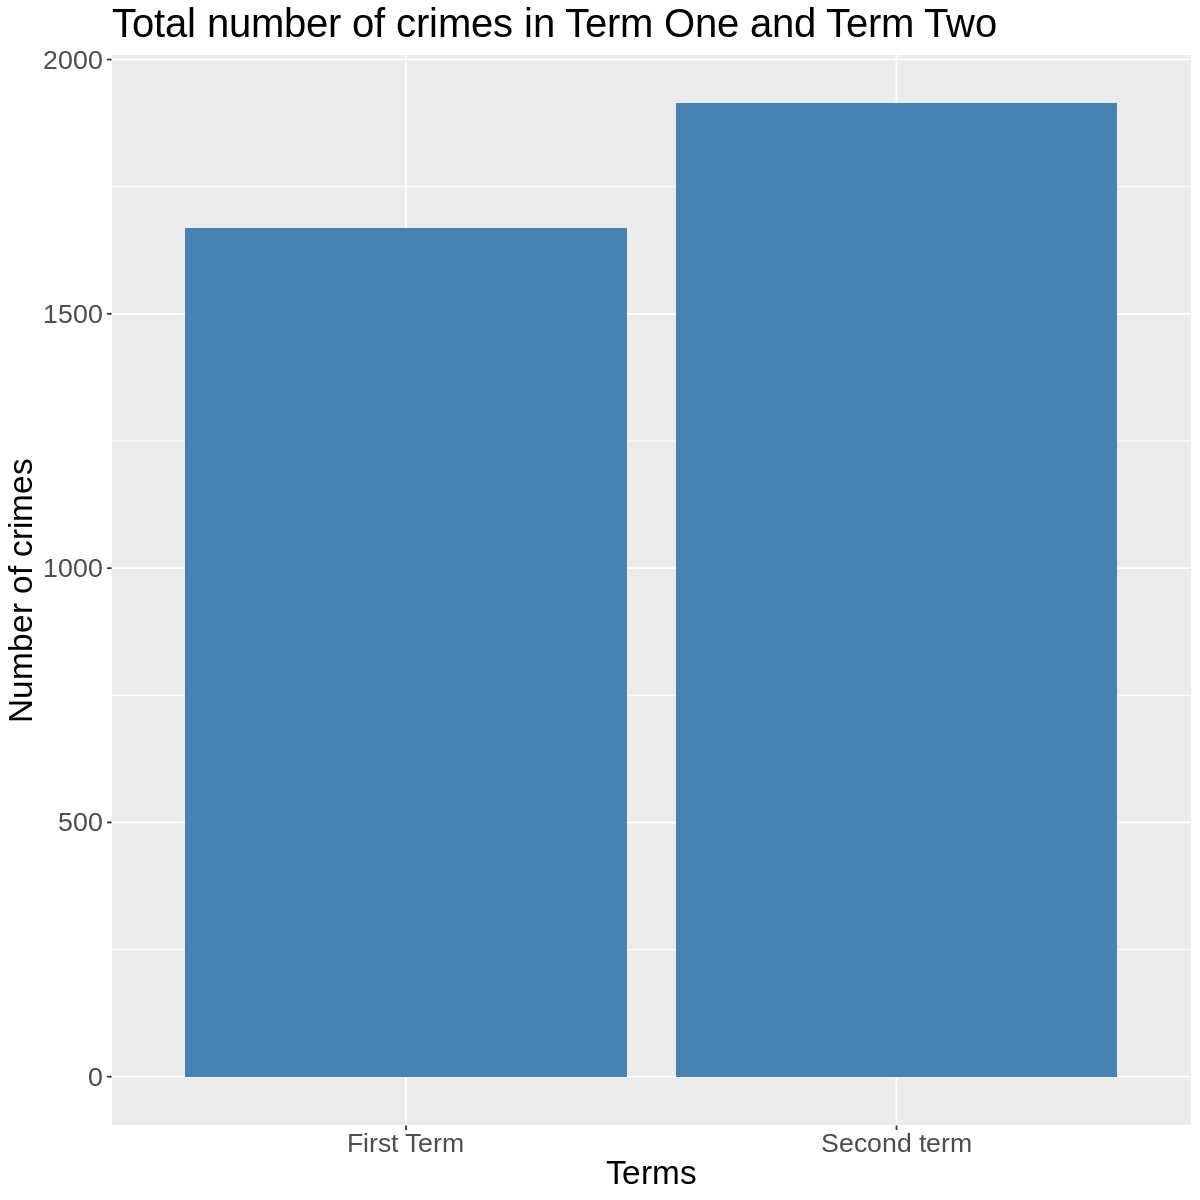

In [202]:
# Bar plot for total number of crimes in both terms
options(repr.plot.width = 10, repr.plot.height = 10)

crimes_by_term_plot <- crimes_by_term %>%
    ggplot(aes(x = terms, num_of_crimes,
               y = num_of_crimes)) +
    geom_bar(stat = "identity", fill = "steelblue") +
    labs(x = "Terms", y = "Number of crimes") +
    ggtitle("Total number of crimes in Term One and Term Two") +
    theme(text = element_text(size = 20))
crimes_by_term_plot

### Finding the rate (# of crimes in  each day/total # of crimes in each term)

In [203]:
# Adding rate column of crimes for each month in both terms

# Number of crimes in each day
crimes_in_day<- vpd_crime_data %>%
    group_by(DAY, MONTH) %>%
    dplyr::summarise(count_crimes = n())
crimes_in_day <- as.data.frame(crimes_in_day)

crimes_rate_term_1 <- crimes_in_day %>%
    filter(MONTH %in% first_term_months) %>%
    mutate(total_num = 1669)

crimes_rate_term_2 <- crimes_in_day %>%
    filter(MONTH %in% second_term_months) %>%
    mutate(total_num = 1914)

crimes_rate <- rbind(crimes_rate_term_1, crimes_rate_term_2) %>%
    mutate(rate = count_crimes/total_num)
head(crimes_rate)

`summarise()` has grouped output by 'DAY'. You can override using the `.groups` argument.



,DAY,MONTH,count_crimes,total_num,rate
,<int>,<int>,<int>,<dbl>,<dbl>
1,1,9,17,1669,0.010185740
2,1,10,22,1669,0.013181546
3,1,11,13,1669,0.007789095
4,1,12,17,1669,0.010185740
5,2,9,15,1669,0.008987418
6,2,10,16,1669,0.009586579


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



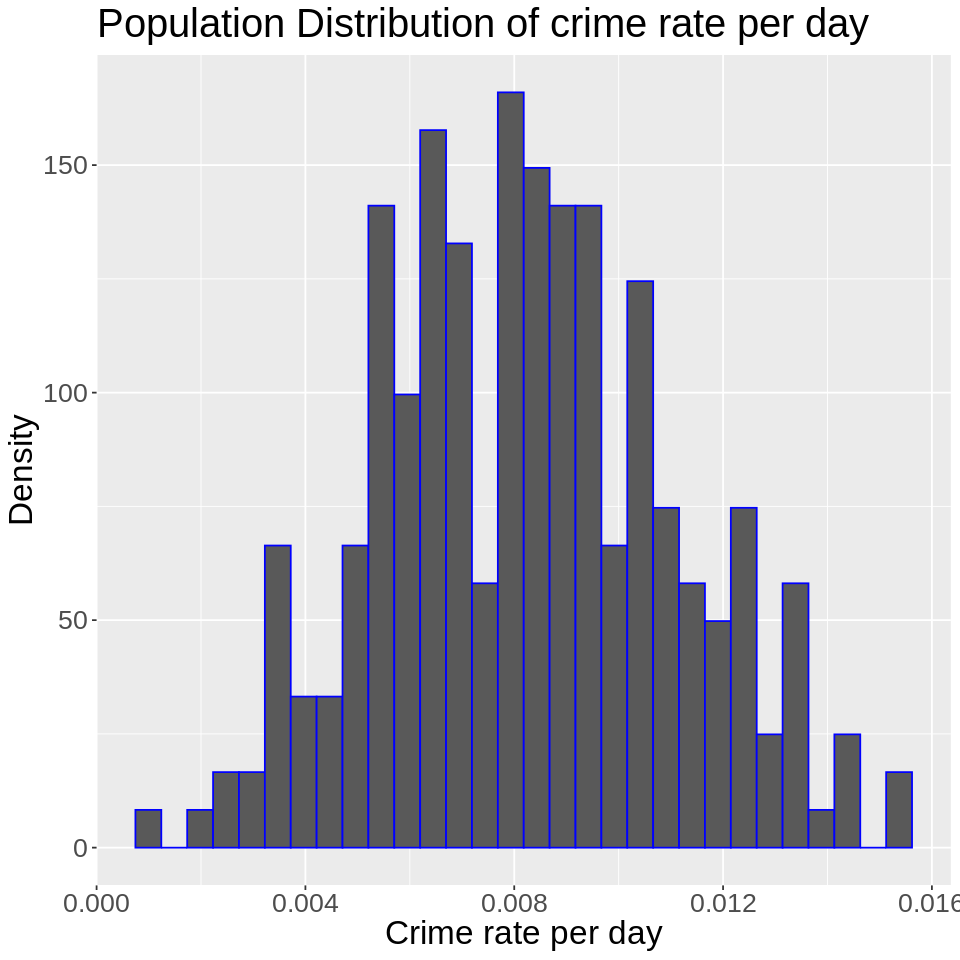

In [204]:
# Population plot
options(repr.plot.width = 8, repr.plot.height = 8)

plot_crimes_rate <- crimes_rate %>%
    ggplot() +
    geom_histogram(aes(x = rate, y = ..density..), color = "blue") +
    theme(text = element_text(size = 20)) +
    xlab("Crime rate per day") +
    ylab("Density") + 
    ggtitle("Population Distribution of crime rate per day")
plot_crimes_rate

### Hypotheses:

H<sub> 0 </sub> : there is no difference in the mean of rate of number of crimes per day in term 1 and 2

H<sub> A </sub> :  there is a difference in the mean of rate of number of crimes per day in term 1 and 2

### Asymptotic

In [205]:
# Finidng the mean and sd for the rate of crimes for both terms together
pop_mu <- mean(crimes_rate$rate)
pop_sd <- sd(crimes_rate$rate)
pop_mu
pop_sd

# Finidng the mean and sd for the rate of crimes for Term One
crimes_rate_term_1 <- crimes_rate %>%
    filter(total_num == "1669")

pop_mu_term_1 <- mean(crimes_rate_term_1$rate)
pop_mu_term_1

pop_sd_term_1 <- sd(crimes_rate_term_1$rate)
pop_sd_term_1


# Finidng the mean and sd for the rate of crimes for Term Two
crimes_rate_term_2 <- crimes_rate %>%
    filter(total_num == "1914")

pop_mu_term_2 <- mean(crimes_rate_term_2$rate)
pop_mu_term_2

pop_sd_term_2 <- sd(crimes_rate_term_2$rate)
pop_sd_term_2

[1] 0.008230453

[1] 0.002813334

[1] 0.008196721

[1] 0.003045667

[1] 0.008264463

[1] 0.002570193

In [207]:
# Sample of size 80
set.seed(40)
sample_80 <- crimes_rate %>%
    ungroup() %>%
    rep_sample_n(size = 80, reps = 500, replace = FALSE) %>%
    group_by(replicate) %>%
    dplyr::summarize(sample_mean_rate = mean(rate))
head(sample_80)

# !!!!
sample_mu <- mean(sample_80$sample_mean_rate)
sample_sd <- sd(sample_80$sample_mean_rate)

# Approximating the sampling distribution
data_normal <- dplyr::tibble(sample_mean_rate = seq(min(sample_80$sample_mean_rate), 
                                    max(sample_80$sample_mean_rate), 0.01), 
                                    density = dnorm(sample_mean_rate, sample_mu, sample_sd))
head(data_normal)

replicate,sample_mean_rate
<int>,<dbl>
1,0.008508007
2,0.007964872
3,0.007908791
4,0.007719334
5,0.008355704
6,0.008550189


sample_mean_rate,density
<dbl>,<dbl>
0.007477811,34.89085


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



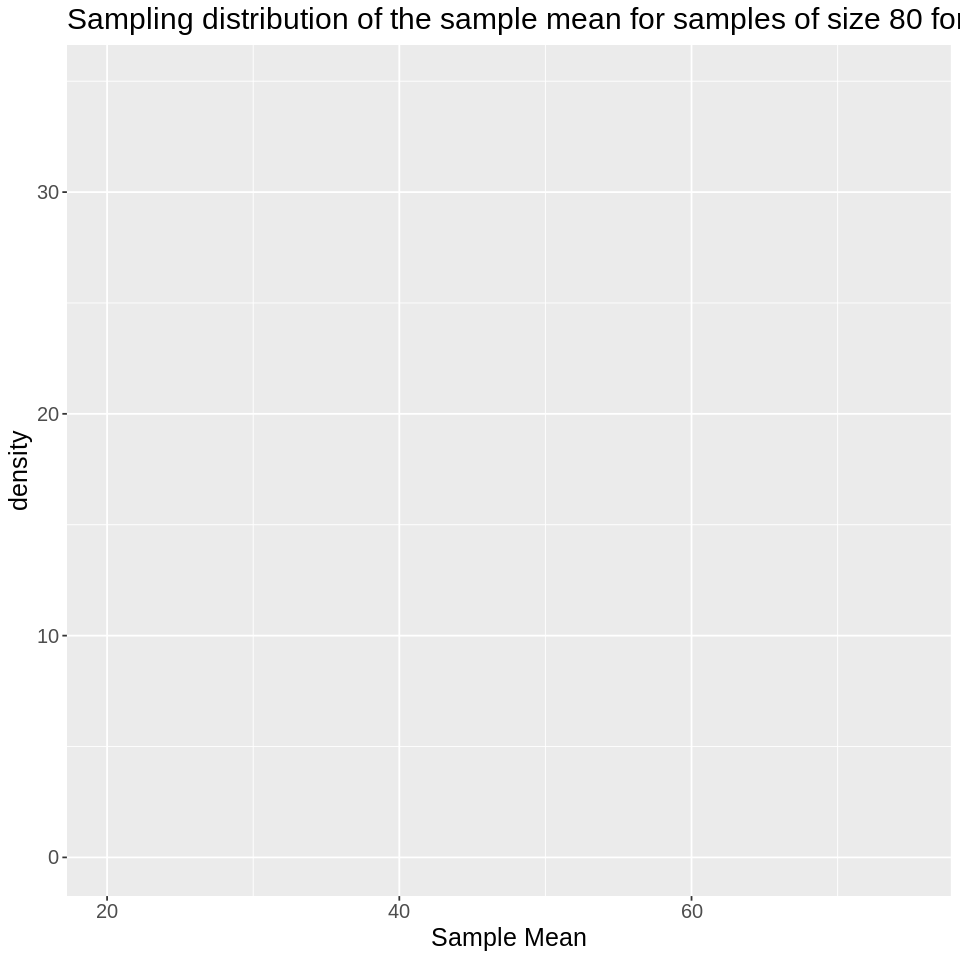

In [168]:
# !!!
options(repr.plot.width = 8, repr.plot.height = 8)

sampling_dist_80 <- sample_80 %>% 
    ggplot() + 
    geom_histogram(aes(x = sample_mean_rate, y = ..density..), binwidth = 2, color = "white") +
    theme(text = element_text(size = 15))+
    xlab("Sample Mean") +
    ggtitle("Sampling distribution of the sample mean for samples of size 80 for Crime in Vancouver") + 
    geom_line(data = data_normal, aes(sample_mean_rate, density), color = "blue", lwd=2) +
    coord_cartesian(xlim = c(20,75)) +
    theme(text = element_text(size = 15))

sampling_dist_80

### Bootstrapping


In [176]:
# Bootstrap with sample size 80
set.seed(45)
one_sample <- crimes_rate %>%
    ungroup() %>%
    rep_sample_n(size = 80, reps = 1, replace = FALSE)

bootstrap_500 <- one_sample %>%
    rep_sample_n(size = 80, reps = 500, replace = TRUE) %>%
    group_by(replicate) %>% 
    dplyr::summarise(sample_mean = mean(rate)) 

head(bootstrap_500)

replicate,sample_mean
<int>,<dbl>
1,0.007593632
2,0.007291356
3,0.008051146
4,0.007330599
5,0.008271101
6,0.008203996


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



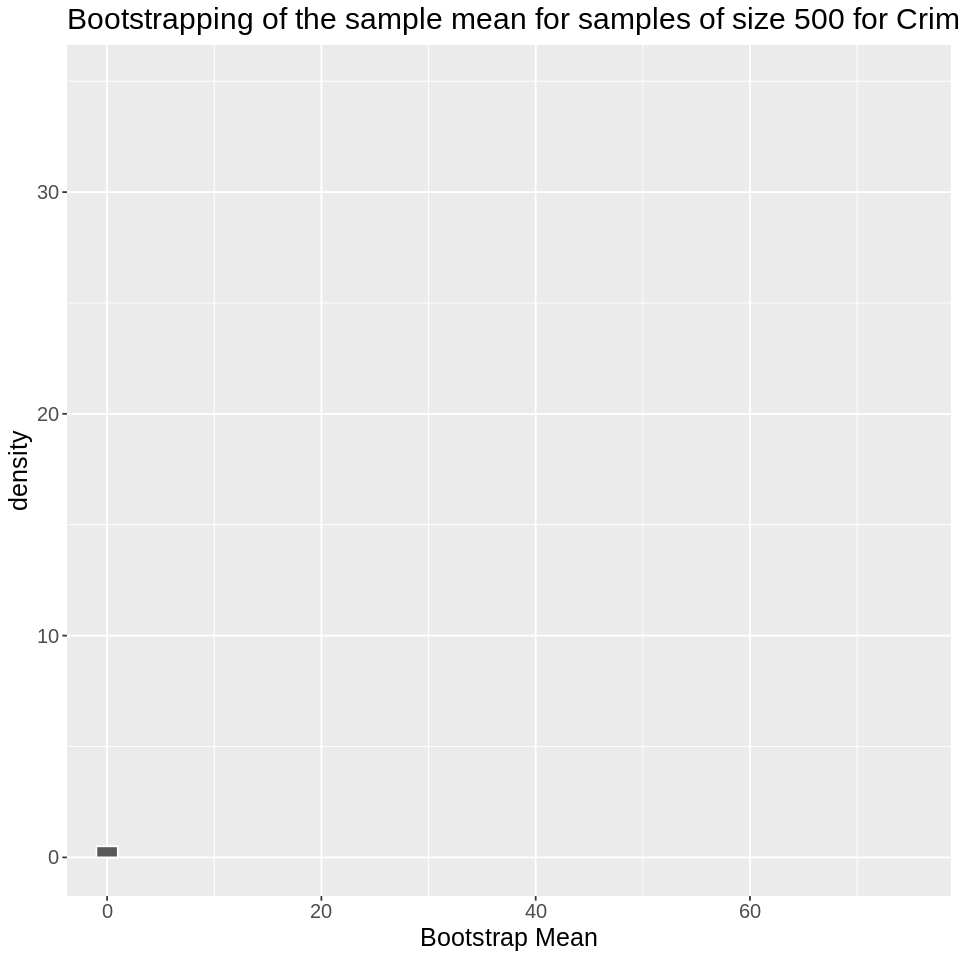

In [180]:
# !!!
options(repr.plot.width = 8, repr.plot.height = 8)

bootstrap_500_plot <- bootstrap_500 %>% 
    ggplot() + 
    geom_histogram(aes(x = sample_mean, y = ..density..), binwidth = 2, color = "white") +
    theme(text = element_text(size = 15)) +
    xlab("Bootstrap Mean") +
    ggtitle("Bootstrapping of the sample mean for samples of size 500 for Crime in Vancouver") + 
    geom_line(data = data_normal, aes(sample_mean_rate, density), color = "blue", lwd = 2) +
    coord_cartesian(xlim = c(0,75))
bootstrap_500_plot

### Hypothesis Testing


In [182]:
# Generating the Null model
null_model_infer <- crimes_rate %>%
    specify(response = rate) %>%
    hypothesise(null = "point", mu = 47.144) %>%
    generate(reps = 500) %>%
    calculate(stat = "mean")
    
head(null_model_infer)

Setting `type = "bootstrap"` in `generate()`.



replicate,stat
<int>,<dbl>
1,47.14439
2,47.14405
3,47.14397
4,47.14409
5,47.14405
6,47.14421


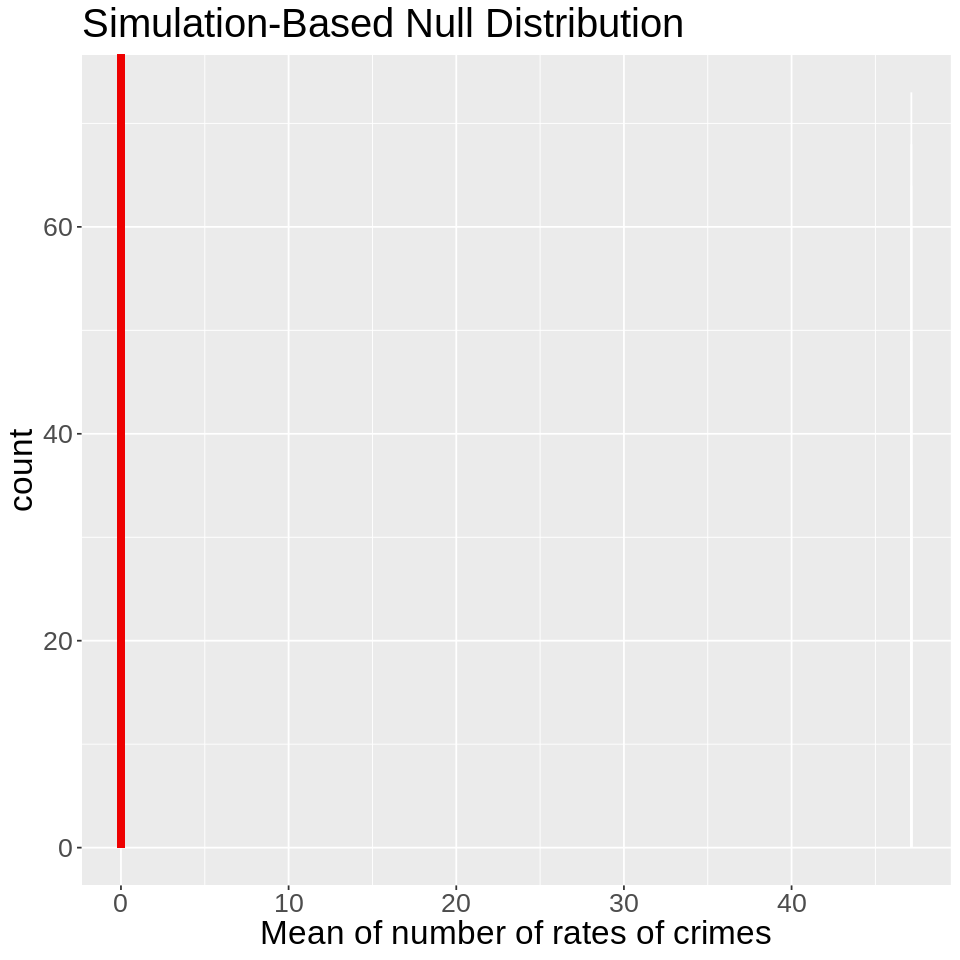

In [184]:
null_model_vis_infer <- null_model_infer %>% 
    visualize() + 
    shade_p_value(obs_stat = pop_mu, direction = "left") +
    xlab("Mean of number of rates of crimes") + 
    theme(text = element_text(size = 20))

null_model_vis_infer